In [46]:
%load_ext autoreload
%autoreload 2

import os
import tqdm
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import display, HTML

import spacy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.data import Dataset, Example, Field
from torchtext.data.iterator import BucketIterator
from torchtext.data.metrics import bleu_score
from torchtext.datasets import Multi30k

import warnings

import utils
import torch_utils
from optim_utils import LRFinder
from beam_utils import Node, find_best_path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')

Device: cuda


In [3]:
%%time
DE = Field(lower=True,
           tokenize='spacy',
           tokenizer_language='de',
           include_lengths=True)
EN = Field(init_token='<sos>',
           eos_token='<eos>',
           lower=True,
           tokenize='spacy',
           tokenizer_language='en',
           include_lengths=True)

train_data, valid_data, test_data = Multi30k.splits(exts=('.de', '.en'),  fields=(DE, EN))
print(f'train set size: {len(train_data.examples):,}')
print(f'valid set size: {len(valid_data.examples):,}')
print(f'test set size: {len(test_data.examples):,}')
print(vars(train_data.examples[0]))

train set size: 29,000
valid set size: 1,014
test set size: 1,000
{'src': ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}
CPU times: user 7.95 s, sys: 256 ms, total: 8.21 s
Wall time: 8.21 s


In [4]:
%%time
MIN_COUNT = 2
DE.build_vocab(train_data,
               min_freq=MIN_COUNT,
               specials=['<unk>', '<pad>'])
EN.build_vocab(train_data,
               min_freq=MIN_COUNT,
               specials=['<sos>', '<eos>', '<unk>', '<pad>'])
print(f'Length of FR vocabulary: {len(DE.vocab):,}')
print(f'Length of EN vocabulary: {len(EN.vocab):,}')

Length of FR vocabulary: 7,852
Length of EN vocabulary: 5,893
CPU times: user 335 ms, sys: 0 ns, total: 335 ms
Wall time: 335 ms


In [5]:
class EncoderLSTM(nn.Module):
    
    def __init__(self, embedding_size, vocab_size, hidden_size, n_layers, embedding_dropout, recurrent_dropout):
        super(EncoderLSTM, self).__init__()
        self.embedding_size = embedding_size
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.embedding_dropout = embedding_dropout
        self.recurrent_dropout = recurrent_dropout
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers=n_layers, bidirectional=True,
                            dropout=(recurrent_dropout if n_layers > 1 else 0))
    
    def forward(self, input_sequences, sequence_lengths):
        """
        :params
            input_sequences: Tensor[seq_len, batch_size]
            sequence_lengths: Tensor[batch_size,]
            
        :return
            h_state: Tensor[n_layers * 2, batch_size, hidden_size]
            c_state: Tensor[n_layers * 2, batch_size, hidden_size]
        """
        embedded = self.embedding(input_sequences)
        embedded = F.dropout(embedded, p=self.embedding_dropout)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, sequence_lengths)
        outputs, (h_state, c_state) = self.lstm(packed)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        return h_state, c_state

In [6]:
class DecoderLSTM(nn.Module):
    
    def __init__(self, embedding_size, vocab_size, hidden_size, n_layers, embedding_dropout, recurrent_dropout):
        super(DecoderLSTM, self).__init__()
        self.embedding_size = embedding_size
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.embedding_dropout = embedding_dropout
        self.recurrent_dropout = recurrent_dropout
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers=n_layers,
                            dropout=(recurrent_dropout if n_layers > 1 else 0))
        self.fc = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, input_word_index, h_state, c_state):
        """
        :params
            input_word_index: Tensor[batch_size,]
            h_state: Tensor[num_layers, batch_size, hidden_size]
            c_state: Tensor[num_layers, batch_size, hidden_size]
            
        :return
            logit: Tensor[batch_size, vocab_size]
            h_state: Tensor[n_layers, batch_size, hidden_size]
            c_state: Tensor[n_layers, batch_size, hidden_size]
        """
        embedded = self.embedding(input_word_index.unsqueeze(0))
        embedded = F.dropout(embedded, p=self.embedding_dropout)
        outputs, (h_state, c_state) = self.lstm(embedded, (h_state, c_state))
        logit = self.fc(outputs).squeeze(0)
        return logit, h_state, c_state

In [24]:
class SeqToSeqLSTM(nn.Module):
    
    def __init__(self, encoder, decoder, device):
        assert encoder.n_layers == decoder.n_layers, 'Encoder and Decoder must have the same number of reccurent layers'
        assert encoder.hidden_size == decoder.hidden_size, 'Encoder and Decoder must have the same number of reccurrent hidden units'
        super(SeqToSeqLSTM, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.init_h0 = nn.Linear(encoder.n_layers * 2, decoder.n_layers) 
        self.init_c0 = nn.Linear(encoder.n_layers * 2, decoder.n_layers)
        self.device = device
        
    def encode(self, input_sequences, sequence_lengths):
        h_state, c_state = self.encoder(input_sequences, sequence_lengths)
        h_state = self.init_h0(h_state.permute(1, 2, 0)) # [batch_size, hidden_size, n_layers]
        c_state = self.init_c0(c_state.permute(1, 2, 0)) # [batch_size, hidden_size, n_layers]
        h_state = h_state.permute(2, 0, 1) # [n_layers, batch_size, hidden_size]
        c_state = c_state.permute(2, 0, 1) # [n_layers, batch_size, hidden_size]
        return h_state, c_state
    
    def sort_batches(self,  h_state, c_state, dest_sequences, dest_lengths):
        sorted_dest_lengths, sorted_indices = torch.sort(dest_lengths, dim=0, descending=True)
        sorted_dest_sequences = dest_sequences[:, sorted_indices]
        h_state = h_state[:, sorted_indices, :]
        c_state = c_state[:, sorted_indices, :]        
        return h_state, c_state, sorted_dest_sequences, sorted_dest_lengths, sorted_indices
    
    def decode(self, sorted_dest_sequences, sorted_decode_lengths, h_state, c_state, tf_ratio):
        batch_size, last = sorted_dest_sequences.size(1), None
        logits = torch.zeros(max(sorted_decode_lengths), batch_size, self.decoder.vocab_size).to(self.device)
        for t in range(max(sorted_decode_lengths)):
            batch_size_t = sum([l > t for l in sorted_decode_lengths])
            if last is not None:
                if np.random.rand() < tf_ratio:
                    in_ = last[:batch_size_t]
                else:
                    in_ = sorted_dest_sequences[t, :batch_size_t]
            else:
                in_ = sorted_dest_sequences[t, :batch_size_t]
            # in_ [batch_size,]
            logit, h_state, c_state = self.decoder(in_, h_state[:, :batch_size_t, :].contiguous(), c_state[:, :batch_size_t, :].contiguous())
            # logit: [batch_size, vocab_size]
            # h_state: [n_layers, batch_size, hidden_size]
            # c_state: [n_layers, batch_size, hidden_size]
            logits[t, :batch_size_t, :] = logit
            last = torch.argmax(F.softmax(logit, dim=1), dim=1) # [batch_size,]
        return logits
    
    def forward(self, src_sequences, src_lengths, dest_sequences, dest_lengths, tf_ratio):
        """
        Args:
            src_sequences: Tensor[seq_len, batch_size]
            src_lengths: Tensor[batch_size,]
            dest_sequences: Tensor[seq_len, batch_size]
            dest_lengths: Tensor[batch_size,]
            tf_ratio: float
            
        Returns:
            logits: Tensor[max(decode_lengths), batch_size, vocab_size]
            sorted_dest_sequences: Tensor[seq_len, batch_size]
            sorted_indices:
        """
        # Encoding
        h_state, c_state = self.encode(src_sequences, src_lengths)
        # Sort the batch (dest) by decreasing lengths
        h_state, c_state, sorted_dest_sequences, sorted_dest_lengths, sorted_indices = self.sort_batches(h_state, c_state, dest_sequences, dest_lengths)
        # We won't decode at the <eos> position, since we've finished generating as soon as we generate <eos>
        # So, decoding lengths are actual lengths - 1
        sorted_decode_lengths = (sorted_dest_lengths - 1).tolist()
        # Decoding
        logits = self.decode(sorted_dest_sequences, sorted_decode_lengths, h_state, c_state, tf_ratio)
        return logits, sorted_dest_sequences, sorted_decode_lengths, sorted_indices

In [25]:
def train_step(model, optimizer, criterion, loader, epoch, grad_clip, tf_ratio, device):
    loss_tracker, acc_tracker = utils.AverageMeter(), utils.AverageMeter()
    model.train()
    pbar = tqdm.tqdm(enumerate(loader), total=len(loader))
    for i, data in pbar:
        # Forward prop.
        logits, sorted_dest_sequences, sorted_decode_lengths, _ = model(*data.src, *data.trg, tf_ratio=tf_ratio)
        # Since we decoded starting with <sos>, the targets are all words after <sos>, up to <eos>
        sorted_dest_sequences = sorted_dest_sequences[1:, :]
        # Remove paddings
        logits = nn.utils.rnn.pack_padded_sequence(logits, sorted_decode_lengths).data
        sorted_dest_sequences = nn.utils.rnn.pack_padded_sequence(sorted_dest_sequences, sorted_decode_lengths).data
        # Calculate loss
        loss = criterion(logits, sorted_dest_sequences)
        # Back prop.
        optimizer.zero_grad()
        loss.backward()
        # Clip gradients
        if grad_clip is not None:
            torch_utils.clip_gradient(optimizer, grad_clip)
        # Update weights
        optimizer.step()
        # Track metrics
        loss_tracker.update(loss.item(), sum(sorted_decode_lengths))
        acc_tracker.update(torch_utils.accuracy(logits, sorted_dest_sequences, 5), sum(sorted_decode_lengths))
        # Update progressbar description
        pbar.set_description(f'Epoch: {epoch + 1:03d} - loss: {loss_tracker.average:.3f} - acc: {acc_tracker.average:.3f}%')
    return loss_tracker.average, acc_tracker.average

In [26]:
def build_references(target_sequences, field):
    references = []
    for j in range(target_sequences.size(0)):
        target_sequence = target_sequences[j].tolist()
        reference = [
            field.vocab.itos[indice] 
            for indice in target_sequence 
            if indice not in (
                field.vocab.stoi[field.init_token],
                field.vocab.stoi[field.pad_token]
            )
        ]
        references.append([reference])
    return references

def build_hypotheses(preds, field, sorted_decode_lengths):
    hypotheses = []
    for j, p in enumerate(preds):
        hypotheses.append([
            field.vocab.itos[indice] 
            for indice in preds[j][:sorted_decode_lengths[j]] # Remove padding
            if indice not in (
                field.vocab.stoi[field.init_token],
                field.vocab.stoi[field.pad_token]
            )
        ])
    return hypotheses

def validate(model, criterion, loader, field, epoch, device):
    references, hypotheses = [], []
    loss_tracker, acc_tracker = utils.AverageMeter(), utils.AverageMeter()
    model.eval()
    with torch.no_grad():
        pbar = tqdm.tqdm(enumerate(loader), total=len(loader))
        for i, data in pbar: 
            # Forward prop.
            logits, sorted_dest_sequences, sorted_decode_lengths, sorted_indices = model(*data.src, *data.trg, tf_ratio=0.)
            # Since we decoded starting with <sos>, the targets are all words after <sos>, up to <eos>
            sorted_dest_sequences = sorted_dest_sequences[1:, :]
            # Remove paddings
            logits_cloned = logits.clone()
            logits = nn.utils.rnn.pack_padded_sequence(logits, sorted_decode_lengths).data
            sorted_dest_sequences = nn.utils.rnn.pack_padded_sequence(sorted_dest_sequences, sorted_decode_lengths).data
            # Calculate loss
            loss = criterion(logits, sorted_dest_sequences)
            # Track metrics
            loss_tracker.update(loss.item(), sum(sorted_decode_lengths))
            acc_tracker.update(torch_utils.accuracy(logits, sorted_dest_sequences, 5), sum(sorted_decode_lengths))
            # Build references
            references = build_references(data.trg[0].t()[sorted_indices], field)
            # Build hypotheses
            _, preds = torch.max(logits_cloned, dim=2)
            hypotheses = build_hypotheses(preds.t().tolist(), field, sorted_decode_lengths)
            assert len(references) == len(hypotheses)
            # Update progressbar description
            pbar.set_description(f'Epoch: {epoch + 1:03d} - val_loss: {loss_tracker.average:.3f} - val_acc: {acc_tracker.average:.3f}%')
        # Calculate BLEU-4 score
        bleu4 = bleu_score(hypotheses, references, max_n=4, weights=[0.25, 0.25, 0.25, 0.25])
        # Display some examples
        for i in np.random.choice(len(loader), size=3, replace=False):
            src, dest = ' '.join(references[i][0]), ' '.join(hypotheses[i])
            display(HTML(f'<span style="color:blue"><b>Ground truth translation:</b> {src}</span>'))
            display(HTML(f'<span style="color:red"><b>Predicted translation:</b> {dest}</span>'))
            print('='*100)
    return loss_tracker.average, acc_tracker.average, bleu4

In [27]:
def train(model, optimizer, criterion, train_loader, valid_loader, field, n_epochs, grad_clip, tf_ratio, last_improv, model_name, device):
    history, best_bleu = {'acc': [], 'loss': [], 'val_acc': [], 'val_loss': [], 'bleu4': []}, 0.
    for epoch in range(n_epochs):
         # Stop training if no improvment since last 4 epochs
        if last_improv == 4:
            print('Training Finished - The model has stopped improving since last 4 epochs')
            break
        # Decay LR if no improvment
        if last_improv > 0:
            torch_utils.adjust_lr(optimizer=optimizer, shrink_factor=0.9, verbose=True)
        # Train step
        loss, acc = train_step(model=model, optimizer=optimizer, criterion=criterion, loader=train_loader, epoch=epoch, grad_clip=grad_clip,
                               tf_ratio=tf_ratio, device=device)
        # Validation step
        val_loss, val_acc, bleu4 = validate(model=model, criterion=criterion, loader=valid_loader, field=field, epoch=epoch, device=device)
        # Update history dict
        history['acc'].append(acc)
        history['loss'].append(loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)
        history['bleu4'].append(bleu4)
        # Print BLEU score
        text = f'BLEU-4: {bleu4*100:.3f}%'
        if bleu4 > best_bleu:
            best_bleu, last_improv = bleu4, 0
        else:
            last_improv += 1
            text += f' - Last improvement since {last_improv} epoch(s)'
        print(text)
        # Decrease teacher forcing rate
        tf_ratio = torch_utils.adjust_tf(tf_ratio, shrink_factor=0.8, verbose=False)
        # Save checkpoint
        torch_utils.save_checkpoint(model=model, optimizer=optimizer, data_name=model_name, epoch=epoch, last_improv=last_improv, bleu4=bleu4,
                                    is_best=bleu4 >= best_bleu)
    return history

In [28]:
MODEL_NAME = 'seq2seq-lstm'
N_LAYERS = 4
HIDDEN_SIZE = 256
EMBEDDING_SIZE = 300
EMBEDDING_DROPOUT = 0.25
RECURRENT_DROPOUT = 0.25
N_EPOCHS = 15
BATCH_SIZE = 64
LR = 3e-4
GRAD_CLIP = 1.0
TF_RATIO = 1.0

In [29]:
encoder = EncoderLSTM(embedding_size=EMBEDDING_SIZE, vocab_size=len(DE.vocab), hidden_size=HIDDEN_SIZE, n_layers=N_LAYERS,
                      embedding_dropout=EMBEDDING_DROPOUT, recurrent_dropout=RECURRENT_DROPOUT)
decoder = DecoderLSTM(embedding_size=EMBEDDING_SIZE, vocab_size=len(EN.vocab), hidden_size=HIDDEN_SIZE, n_layers=N_LAYERS,
                      embedding_dropout=EMBEDDING_DROPOUT, recurrent_dropout=RECURRENT_DROPOUT)
seq2seq = SeqToSeqLSTM(encoder=encoder, decoder=decoder, device=DEVICE)
seq2seq.apply(torch_utils.xavier_init_weights)
seq2seq.to(DEVICE)
optimizer = optim.RMSprop(params=seq2seq.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
print(f'Number of parameters of the model: {torch_utils.count_parameters(seq2seq):,}')

Number of parameters of the model: 13,662,137


In [30]:
train_iterator, valid_iterator, test_iterator =  BucketIterator.splits((train_data, valid_data, test_data),
                                                                       batch_size=BATCH_SIZE,
                                                                       sort_key=lambda x: len(x.src),
                                                                       sort_within_batch=True, device=DEVICE)

In [31]:
%%time
history = train(model=seq2seq, optimizer=optimizer, criterion=criterion, train_loader=train_iterator, valid_loader=valid_iterator,
                field=EN, n_epochs=N_EPOCHS, grad_clip=GRAD_CLIP, tf_ratio=TF_RATIO, last_improv=0, model_name=MODEL_NAME, device=DEVICE)

Epoch: 001 - val_loss: 4.526 - val_acc: 6.989%: 100%|██████████| 16/16 [00:00<00:00, 25.55it/s]


BLEU-4: 2.950%


Epoch: 002 - val_loss: 4.251 - val_acc: 7.581%: 100%|██████████| 16/16 [00:00<00:00, 25.69it/s]


BLEU-4: 3.470%


Epoch: 003 - val_loss: 3.775 - val_acc: 8.550%: 100%|██████████| 16/16 [00:00<00:00, 26.33it/s]


BLEU-4: 5.401%


Epoch: 004 - val_loss: 3.502 - val_acc: 9.179%: 100%|██████████| 16/16 [00:00<00:00, 25.54it/s]


BLEU-4: 6.499%


Epoch: 005 - val_loss: 3.326 - val_acc: 9.600%: 100%|██████████| 16/16 [00:00<00:00, 24.05it/s]


BLEU-4: 8.127%


Epoch: 006 - val_loss: 3.166 - val_acc: 9.972%: 100%|██████████| 16/16 [00:00<00:00, 25.86it/s]


BLEU-4: 8.176%


Epoch: 007 - val_loss: 3.015 - val_acc: 10.273%: 100%|██████████| 16/16 [00:00<00:00, 24.07it/s]


BLEU-4: 8.895%


Epoch: 008 - val_loss: 2.911 - val_acc: 10.556%: 100%|██████████| 16/16 [00:00<00:00, 24.83it/s]


BLEU-4: 9.487%


Epoch: 009 - val_loss: 2.825 - val_acc: 10.707%: 100%|██████████| 16/16 [00:00<00:00, 24.78it/s]


BLEU-4: 9.894%


Epoch: 010 - val_loss: 2.735 - val_acc: 10.938%: 100%|██████████| 16/16 [00:00<00:00, 25.97it/s]


BLEU-4: 9.338% - Last improvement since 1 epoch(s)


Epoch: 011 - loss: 3.186 - acc: 13.338%:   0%|          | 1/454 [00:00<01:12,  6.22it/s]


Decaying learning rate.
The new learning rate is 0.000270



Epoch: 011 - val_loss: 2.681 - val_acc: 11.067%: 100%|██████████| 16/16 [00:00<00:00, 24.47it/s]


BLEU-4: 11.326%


Epoch: 012 - val_loss: 2.622 - val_acc: 11.241%: 100%|██████████| 16/16 [00:00<00:00, 26.04it/s]


BLEU-4: 11.859%


Epoch: 013 - val_loss: 2.584 - val_acc: 11.300%: 100%|██████████| 16/16 [00:00<00:00, 25.35it/s]


BLEU-4: 13.005%


Epoch: 014 - val_loss: 2.542 - val_acc: 11.402%: 100%|██████████| 16/16 [00:00<00:00, 27.00it/s]


BLEU-4: 13.244%


Epoch: 015 - val_loss: 2.501 - val_acc: 11.472%: 100%|██████████| 16/16 [00:00<00:00, 27.38it/s]


BLEU-4: 12.617% - Last improvement since 1 epoch(s)
CPU times: user 12min 54s, sys: 1min 17s, total: 14min 11s
Wall time: 10min 49s


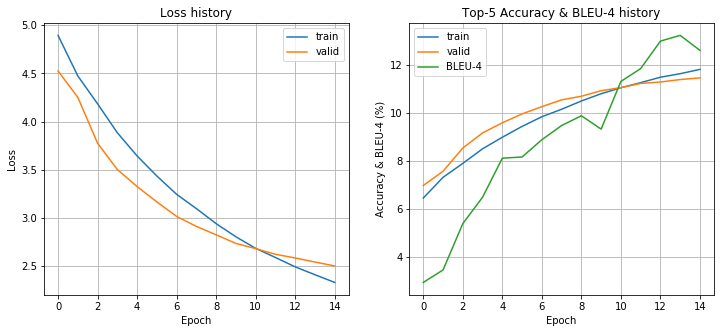

In [32]:
_, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(history['loss'], label='train')
axes[0].plot(history['val_loss'], label='valid')
axes[0].set_title('Loss history')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)
axes[0].legend()
axes[1].plot(history['acc'], label='train')
axes[1].plot(history['val_acc'], label='valid')
axes[1].plot(np.array(history['bleu4']) * 100., label='BLEU-4')
axes[1].set_title('Top-5 Accuracy & BLEU-4 history')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy & BLEU-4 (%)')
axes[1].grid(True)
axes[1].legend()
plt.show()

In [33]:
seq2seq.load_state_dict(torch.load(f'./checkpoint/BEST_{MODEL_NAME}.pt').get('model'))

<All keys matched successfully>

In [34]:
def evaluate(model, loader, beam_size, src_field, dest_field, max_len, device):
    references, hypotheses, sources = [], [], []
    model.eval()
    with torch.no_grad():
        pbar = tqdm.tqdm(enumerate(loader), total=len(loader))
        for i, data in pbar:
            (src_sequences, src_lengths) = data.src[0], data.src[1]
            (dest_sequences, dest_lengths) = data.trg[0], data.trg[1]
            
            batch_size = src_sequences.shape[1]
            for j in range(batch_size): # We evaluate sentence by sentence
                src_sequence = src_sequences[:, j].unsqueeze(1) # [seq_len, 1]
                dest_sequence = dest_sequences[:, j].unsqueeze(1) # [seq_len, 1]
                src_length, dest_length = src_lengths[j, None], dest_lengths[j, None] # [1,]
                
                # Encoding
                h_state, c_state = model.encoder(input_sequences=src_sequence, sequence_lengths=src_length)
                
                # Init hidden and memory states
                h_state = model.init_h0(h_state.permute(1, 2, 0)) # [batch_size, hidden_size, n_layers]
                c_state = model.init_c0(c_state.permute(1, 2, 0)) # [batch_size, hidden_size, n_layers]
                h_state = h_state.permute(2, 0, 1) # [n_layers, batch_size, hidden_size]
                c_state = c_state.permute(2, 0, 1) # [n_layers, batch_size, hidden_size]
                
                # Decoding
                tree = [[Node(token=torch.LongTensor([dest_field.vocab.stoi[dest_field.init_token]]).to(device), states=(h_state, c_state))]]
                
                for _ in range(max_len):
                    next_nodes = []
                    for node in tree[-1]:
                        # Skip eos token
                        if node.eos:
                            continue
                        # Decode
                        logit, h_state, c_state = model.decoder(input_word_index=node.token,
                                                                h_state=node.states[0].contiguous(),
                                                                c_state=node.states[1].contiguous())
                        # logit: [1, vocab_size]
                        # h_state: [n_layers, 1, hidden_size]
                        # c_state: [n_layers, 1, hidden_size]

                        # Get scores
                        logp = F.log_softmax(logit, dim=1).squeeze(dim=0) # [vocab_size]

                        # Get top k tokens & logps
                        topk_logps, topk_tokens = torch.topk(logp, beam_size)

                        for k in range(beam_size):
                            next_nodes.append(Node(token=topk_tokens[k, None],
                                                   states=(h_state, c_state),
                                                   logp=topk_logps[k, None].cpu().item(),
                                                   parent=node,
                                                   eos=topk_tokens[k].cpu().item() == dest_field.vocab[dest_field.eos_token]))
                    
                    if len(next_nodes) == 0:
                        break
                    
                    # Sort next_nodes to get the best
                    next_nodes = sorted(next_nodes, key=lambda node: node.logps, reverse=True)
                    
                    # Update the tree
                    tree.append(next_nodes[:beam_size])
                
                # Find the best path of the tree
                best_path = find_best_path(tree)
                
                # Get the translation
                pred_translated = [*map(lambda node: dest_field.vocab.itos[node.token], best_path)]
                pred_translated = [*filter(lambda word: word not in [
                    dest_field.init_token, dest_field.eos_token
                ], pred_translated[::-1])]
                
                # Update hypotheses
                hypotheses.append(pred_translated)
                
                # Update references
                references.append([[
                    dest_field.vocab.itos[indice] 
                    for indice in dest_sequence 
                    if indice not in (
                        dest_field.vocab.stoi[dest_field.init_token],
                        dest_field.vocab.stoi[dest_field.eos_token],
                        dest_field.vocab.stoi[dest_field.pad_token]
                    )
                ]])
                
                # Update sources
                sources.append([
                    src_field.vocab.itos[indice] 
                    for indice in src_sequence 
                    if indice not in (
                        src_field.vocab.stoi[src_field.init_token],
                        src_field.vocab.stoi[src_field.eos_token],
                        src_field.vocab.stoi[src_field.pad_token]
                    )
                ])
    
        # Calculate BLEU-4 score
        assert len(hypotheses) == len(references) == len(sources)
        bleu4 = bleu_score(hypotheses, references, max_n=4, weights=[0.25, 0.25, 0.25, 0.25])
    
    return hypotheses, references, sources, bleu4

In [37]:
_, _, _, bleu4 = evaluate(seq2seq.to(DEVICE), loader=test_iterator, beam_size=1, src_field=DE, dest_field=EN, max_len=50, device=DEVICE)
print(f'BLEU-4: {bleu4*100:.3f}% with beam_size=1')

100%|██████████| 16/16 [00:19<00:00,  1.20s/it]


BLEU-4: 20.210% with beam_size=1


In [57]:
_, _, _, bleu4 = evaluate(seq2seq.to(DEVICE), loader=valid_iterator, beam_size=1, src_field=DE, dest_field=EN, max_len=50, device=DEVICE)
print(f'BLEU-4: {bleu4*100:.3f}% with beam_size=1')

100%|██████████| 16/16 [00:19<00:00,  1.24s/it]


BLEU-4: 19.239% with beam_size=1


In [38]:
_, _, _, bleu4 = evaluate(seq2seq.to(DEVICE), loader=test_iterator, beam_size=3, src_field=DE, dest_field=EN, max_len=50, device=DEVICE)
print(f'BLEU-4: {bleu4*100:.3f}% with beam_size=3')

100%|██████████| 16/16 [01:27<00:00,  5.48s/it]


BLEU-4: 20.113% with beam_size=3


In [39]:
_, _, _, bleu4 = evaluate(seq2seq.to(DEVICE), loader=test_iterator, beam_size=5, src_field=DE, dest_field=EN, max_len=50, device=DEVICE)
print(f'BLEU-4: {bleu4*100:.3f}% with beam_size=5')

100%|██████████| 16/16 [02:58<00:00, 11.15s/it]


BLEU-4: 19.799% with beam_size=5


In [48]:
def translate(sentences, model, beam_size, src_field, dest_field, max_len, device):
    """
    Translate sentences
    """
    if isinstance(sentences, list):
        sentences = [*map(src_field.preprocess, sentences)]
        targets = None
    if isinstance(sentences, Dataset):
        targets = [*map(lambda example: ' '.join(example.trg), sentences.examples)]
        sentences = [*map(lambda example: example.src, sentences.examples)]
    data = [*map(lambda word_list: src_field.process([word_list]), sentences)]
    
    translated_sentences, pred_logps = [], []
    
    model.eval()
    with torch.no_grad():
        pbar = tqdm.tqdm(enumerate(data), total=len(data))
        for i, (src_sequence, src_length) in pbar:
            src_sequence, src_length = src_sequence.to(device), src_length.to(device)
                
            # Encoding
            h_state, c_state = model.encoder(input_sequences=src_sequence, sequence_lengths=src_length)
                
            # Init hidden and memory states
            h_state = model.init_h0(h_state.permute(1, 2, 0)) # [1, hidden_size, n_layers]
            c_state = model.init_c0(c_state.permute(1, 2, 0)) # [1, hidden_size, n_layers]
            h_state = h_state.permute(2, 0, 1) # [n_layers, 1, hidden_size]
            c_state = c_state.permute(2, 0, 1) # [n_layers, 1, hidden_size]
                
            # Decoding
            tree = [[Node(token=torch.LongTensor([dest_field.vocab.stoi[dest_field.init_token]]).to(device), states=(h_state, c_state))]]
               
            # Generate tokens
            for _ in range(max_len):
                next_nodes = []
                for node in tree[-1]:
                    # Skip eos token
                    if node.eos:
                        continue
                    # Decode
                    logit, h_state, c_state = model.decoder(input_word_index=node.token, 
                                                            h_state=node.states[0].contiguous(),
                                                            c_state=node.states[1].contiguous())
                    # logit: [1, vocab_size]
                    # h_state: [n_layers, 1, hidden_size]
                    # c_state: [n_layers, 1, hidden_size]

                    # Get scores
                    logp = F.log_softmax(logit, dim=1).squeeze(dim=0) # [vocab_size]

                    # Get top k tokens & logps
                    topk_logps, topk_tokens = torch.topk(logp, beam_size)

                    for k in range(beam_size):
                        next_nodes.append(Node(token=topk_tokens[k, None],
                                               states=(h_state, c_state),
                                               logp=topk_logps[k, None].cpu().item(),
                                               parent=node,
                                               eos=topk_tokens[k].cpu().item() == dest_field.vocab[dest_field.eos_token]))
                
                if len(next_nodes) == 0:
                    break

                # Sort next_nodes to get the best
                next_nodes = sorted(next_nodes, key=lambda node: node.logps, reverse=True)
                
                # Update the tree
                tree.append(next_nodes[:beam_size])
                
            # Find the best path of the tree
            best_path = find_best_path(tree)

            # Get the translation
            pred_translated = [*map(lambda node: dest_field.vocab.itos[node.token], best_path)]
            pred_translated = [*filter(lambda word: word not in [
                dest_field.init_token, dest_field.eos_token
            ], pred_translated[::-1])]
            translated_sentences.append(' '.join(pred_translated))
            
            # Get probabilities
            pred_logps.append(sum([*map(lambda node: node.logps, best_path)]))
            
            
        sentences = [*map(lambda sentence: ' '.join(sentence), sentences)]
    return sentences, translated_sentences, targets, pred_logps

In [49]:
sentences, translated_sentences, dest_sentences, pred_logps = translate(sentences=test_data, model=seq2seq, beam_size=1, src_field=DE,
                                                                        dest_field=EN, max_len=50, device=DEVICE)
indexes = np.random.choice(len(test_data.examples), size=20, replace=False)
print(indexes)
print()
for i in indexes:
    html = f'<p><span style="color:blue"><b>Source:</b> {sentences[i]}</span><br />'
    html += f'<span style="color:green"><b>Ground truth translation:</b> {dest_sentences[i]}</span><br />'
    html += f'<span style="color:red"><b>Predicted translation:</b> {translated_sentences[i]}</span></p>'
    display(HTML(html))
    print('='*100)

100%|██████████| 1000/1000 [00:14<00:00, 70.51it/s]

[605 575 686 942 425 426  64 595 562 841 302  66 527 471 451  67 608  12
 221 355]



In [50]:
def get_dest_logp(model, data, src_field, dest_field, device):
    dest_logps = []
        
    model.eval()
    with torch.no_grad():
        pbar = tqdm.tqdm(enumerate(data), total=len(data))
        for i, data in pbar:
            src_sequence, src_length = src_field.process([data.src])
            dest_sequence, dest_length = dest_field.process([data.trg])
            src_sequence, src_length = src_sequence.to(device), src_length.to(device)
            dest_sequence, dest_length = dest_sequence.to(device), dest_length.to(device)
                
            # Encoding
            h_state, c_state = model.encoder(input_sequences=src_sequence, sequence_lengths=src_length)
                
            # Init hidden and memory states
            h_state = model.init_h0(h_state.permute(1, 2, 0)) # [1, hidden_size, n_layers]
            c_state = model.init_c0(c_state.permute(1, 2, 0)) # [1, hidden_size, n_layers]
            h_state = h_state.permute(2, 0, 1) # [n_layers, 1, hidden_size]
            c_state = c_state.permute(2, 0, 1) # [n_layers, 1, hidden_size]
            
            logps = []
            
            # Decoding
            input_word_index = torch.LongTensor([dest_field.vocab.stoi[dest_field.init_token]]).to(device)
            
            # Generate tokens
            for idx in range(dest_sequence.shape[0]):
                # Decode
                logit, h_state, c_state = model.decoder(input_word_index=input_word_index, 
                                                        h_state=h_state.contiguous(),
                                                        c_state=c_state.contiguous())
                # logit: [1, vocab_size]
                # h_state: [n_layers, 1, hidden_size]
                # c_state: [n_layers, 1, hidden_size]
                
                # Get scores
                logp = F.log_softmax(logit, dim=1).squeeze(dim=0) # [vocab_size]
                
                # Get logp of ground truth ouput
                input_word_index = dest_sequence[idx]
                logps.append(logp[input_word_index].cpu().item())
                
            dest_logps.append(sum(logps))
    
    return dest_logps

dest_logps = get_dest_logp(model=seq2seq, data=test_data, src_field=DE, dest_field=EN, device=DEVICE)

100%|██████████| 1000/1000 [00:13<00:00, 73.06it/s]


In [51]:
assert len(pred_logps) == len(dest_logps) == len(test_data), f'{len(pred_logps)}, {len(dest_logps)}, {len(test_data)}'

In [52]:
beam_search_faults = np.array(dest_logps) > np.array(pred_logps)

beam_search_fault_rate = beam_search_faults.sum() / beam_search_faults.size
print(f'Beam search fault rate: {beam_search_fault_rate * 100:.3f}%')
print(f'Model fault rate: {(1 - beam_search_fault_rate) * 100:.3f}%')

Beam search fault rate: 66.900%
Model fault rate: 33.100%


In [53]:
beam_search_fault_indexes = np.where(beam_search_faults == True)[0]
model_fault_indexes = np.where(beam_search_faults == False)[0]

In [54]:
for i in np.random.choice(beam_search_fault_indexes, size=5, replace=False):
    html = f'<p><span style="color:blue"><b>Source:</b> {sentences[i]}</span><br />'
    html += f'<span style="color:green"><b>Ground truth translation:</b> {dest_sentences[i]}</span><br />'
    html += f'<span style="color:red"><b>Predicted translation (Beam search fault):</b> {translated_sentences[i]}</span><br />'
    display(HTML(html))
    print('='*100)

In [55]:
for i in np.random.choice(model_fault_indexes, size=5, replace=False):
    html = f'<p><span><b>Source:</b> {sentences[i]}</span><br />'
    html += f'<span style="color:green"><b>Ground truth translation:</b> {dest_sentences[i]}</span><br />'
    html += f'<span style="color:blue"><b>Predicted translation (Model fault):</b> {translated_sentences[i]}</span><br />'
    display(HTML(html))
    print('='*100)

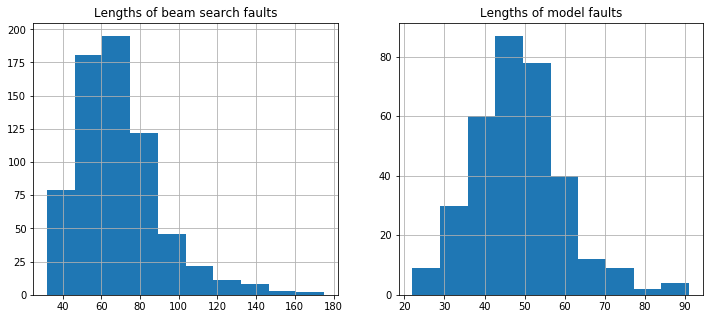

In [56]:
lengths = np.array([*map(len, dest_sentences)])

_, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist(lengths[beam_search_fault_indexes])
axes[0].set_title('Lengths of beam search faults')
axes[0].grid(True)
axes[1].hist(lengths[model_fault_indexes])
axes[1].set_title('Lengths of model faults')
axes[1].grid(True)
plt.show()